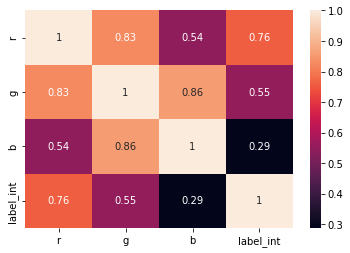

In [1]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import dill


import pandas as pd
df = pd.read_csv(r"./csv/clipped/all.csv", encoding="utf-8-sig", delimiter=',', thousands=r',', dtype=None, chunksize=None)
df.head()

X = df.drop(columns=['label','label_int'])
y = df['label_int']

import matplotlib.pyplot as plt
import seaborn as sns
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=True)
plt.show()

[0.83067448 0.1521417 ]


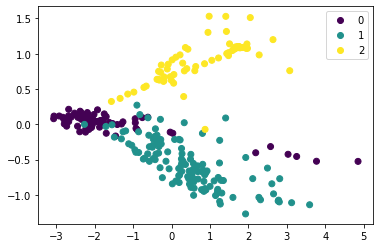

In [4]:
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.legend(handles=scatter.legend_elements()[0], labels=[0,1,2])

In [5]:
from sklearn.model_selection import train_test_split
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import StackingClassifier
import numpy as np


def get_stacking_model():
    lv0 = [
        ('svc', SVC()),
        ('dt_clf', DecisionTreeClassifier()),
        ('knn_clf', KNeighborsClassifier()),
        ('rf_clf', RandomForestClassifier()),
        ('xgboost_clf', XGBClassifier()),
        ('gnb_clf', GaussianNB()),
        # ('mn_clf', MultinomialNB()),
        # ('cat_clf', CategoricalNB()),
    ]
    lv1 = LogisticRegression()
    model = StackingClassifier(estimators=lv0, final_estimator=lv1, cv=5)
    return model


def get_models():
    models = {
        'stacking': get_stacking_model(),
        'svc': SVC(),
        'dt_clf': DecisionTreeClassifier(),
        'knn_clf': KNeighborsClassifier(),
        'rf_clf': RandomForestClassifier(),
        'xgboost_clf': XGBClassifier(),
        'gnb_clf': GaussianNB(),
        # 'mn_clf': MultinomialNB(),
        # 'cat_clf': CategoricalNB(),  
    }
    return models


def cross_evaluate_model(model, X, y):
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    return scores

models = get_models()
score_list = []
for clf, model in models.items():
    scores = cross_evaluate_model(model, X_pca, y)
    print(f'{clf}: {-np.mean(scores)}')

stacking: 0.09761904761904762
svc: 0.14074074074074075
dt_clf: 0.11203703703703702
knn_clf: 0.13690476190476192
rf_clf: 0.13002645502645502
xgboost_clf: 0.10820105820105819
gnb_clf: 0.15515873015873013


Fitting 10 folds for each of 25 candidates, totalling 250 fits
DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)
accuracy = 0.9272727272727272
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        14
           1       0.88      0.96      0.92        24
           2       1.00      1.00      1.00        17

    accuracy                           0.93        55
   macro avg       0.93      0.91      0.92        55
weighted avg       0.93      0.93      0.93        55



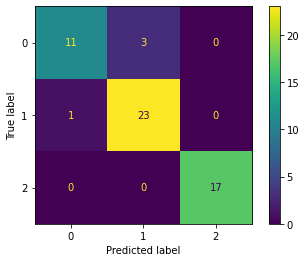

In [14]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import shutup
shutup.please()

dt_clf = DecisionTreeClassifier()
param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
}
dt_clf_lowest_mse = GridSearchCV(dt_clf, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
dt_clf_lowest_mse.fit(X_pca_train, y_train)
print(dt_clf_lowest_mse.best_estimator_)

from sklearn import metrics
y_pred = dt_clf_lowest_mse.predict(X_pca_test)
print('accuracy =', metrics.accuracy_score(y_test, y_pred))


from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(dt_clf_lowest_mse, X_pca_test, y_test)  
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
accuracy = 0.9636363636363636
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.96      0.96      0.96        24
           2       1.00      1.00      1.00        17

    accuracy                           0.96        55
   macro avg       0.96      0.96      0.96        55
weighted avg       0.96      0.96      0.96        55

SVC(C=10.0, gamma=1.0)
lowest RMSE = 0.26967994498529685


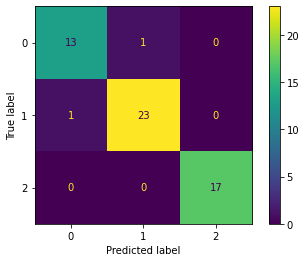

In [16]:
import shutup
shutup.please()


from sklearn.svm import SVC
import numpy as np
svc = SVC()
param_grid = {
    'kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 
    'C': [np.float_power(10, i) for i in np.arange(-5, 5, 1)],
    'gamma': [np.float_power(10, i) for i in np.arange(0, -5, -1)],
    # 'epsilon': [0.07, 0.085]
}
svc_lowest_mse = GridSearchCV(svc, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
svc_lowest_mse.fit(X_pca_train, y_train)

accuracy = 0.9636363636363636
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.96      0.96      0.96        24
           2       1.00      1.00      1.00        17

    accuracy                           0.96        55
   macro avg       0.96      0.96      0.96        55
weighted avg       0.96      0.96      0.96        55

SVC(C=10.0, gamma=1.0)
lowest RMSE = 0.26967994498529685


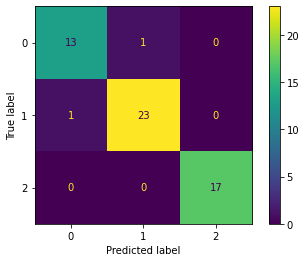

In [17]:
from sklearn import metrics
y_pred = svc_lowest_mse.predict(X_pca_test)
print('accuracy =', metrics.accuracy_score(y_test, y_pred))


from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(svc_lowest_mse, X_pca_test, y_test)  
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))


from numpy import average, median
print(svc_lowest_mse.best_estimator_)
rmse_lowest = (-svc_lowest_mse.best_score_)**(1/2.0)
print("lowest RMSE =", rmse_lowest)

In [13]:
import shutup
shutup.please()

estimators = [
    ('svc', SVC()),
    ('dt_clf', DecisionTreeClassifier()),
    ('knn_clf', KNeighborsClassifier()),
    ('rf_clf', RandomForestClassifier()),
    ('xgboost_clf', XGBClassifier()),
    ('gnb_clf', GaussianNB()),
    # ('mn_clf', MultinomialNB()),
    # ('cat_clf', CategoricalNB()),
]

sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
sclf.fit(X_pca_train, y_train)
y_pred = sclf.predict(X_pca_test)


from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

ERROR! Session/line number was not unique in database. History logging moved to new session 104
[21:06:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:06:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:06:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like 

In [18]:
estimators = [
    ('svc', SVC()),
    ('dt_clf', DecisionTreeClassifier()),
    ('knn_clf', KNeighborsClassifier()),
    ('rf_clf', RandomForestClassifier()),
    ('xgboost_clf', XGBClassifier()),
    ('gnb_clf', GaussianNB()),
    # ('mn_clf', MultinomialNB()),
    # ('cat_clf', CategoricalNB()),
]
param_grid = {
    # 'svc__kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 
    'svc__C': [10],
    'svc__gamma': [1],
    # 'knn__n_neighbors': np.arange(1, 200, 1),
    'dt_clf__max_depth': [2],
    'dt_clf__min_samples_leaf': [5],
}


sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
grid = GridSearchCV(estimator=sclf, param_grid=param_grid, cv=10, n_jobs=-1)
grid.fit(X_pca_train, y_train)
y_pred = grid.predict(X_pca_test)
from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

[21:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

Fitting 10 folds for each of 199 candidates, totalling 1990 fits
accuracy = 0.9454545454545454
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        14
           1       1.00      0.88      0.93        24
           2       1.00      1.00      1.00        17

    accuracy                           0.95        55
   macro avg       0.94      0.96      0.95        55
weighted avg       0.96      0.95      0.95        55

KNeighborsClassifier(n_neighbors=2)
lowest RMSE = 0.3089571903266623


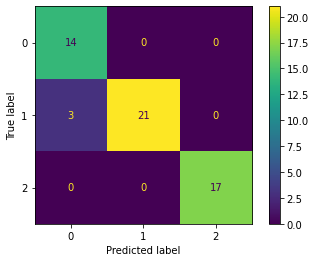

In [6]:
import shutup
shutup.please()


from sklearn.neighbors import KNeighborsClassifier
import numpy as np
knn_clf = KNeighborsClassifier()
param_grid = {
    "n_neighbors": np.arange(1, 200, 1)
}
knn_clf_lowest_mse = GridSearchCV(knn_clf, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1)
knn_clf_lowest_mse.fit(X_pca_train, y_train)


from sklearn import metrics
y_pred = knn_clf_lowest_mse.predict(X_pca_test)
print('accuracy =', metrics.accuracy_score(y_test, y_pred))


from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(knn_clf_lowest_mse, X_pca_test, y_test)  
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))


from numpy import average, median
print(knn_clf_lowest_mse.best_estimator_)
rmse_lowest = (-knn_clf_lowest_mse.best_score_)**(1/2.0)
print("lowest RMSE =", rmse_lowest)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
y_pred = gnb_clf.predict(X_test)

from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

accuracy = 0.8181818181818182


In [9]:
from sklearn.naive_bayes import CategoricalNB
catnb_clf = CategoricalNB()
catnb_clf.fit(X_train, y_train)
y_pred = catnb_clf.predict(X_test)

from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

accuracy = 0.7454545454545455


In [10]:
from sklearn.naive_bayes import MultinomialNB
mnnb_clf = MultinomialNB()
mnnb_clf.fit(X_train, y_train)
y_pred = mnnb_clf.predict(X_test)

from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_test, y_pred))

accuracy = 0.8727272727272727


In [5]:
import joblib
joblib.dump(grid, 'models/best_stacking.pkl')

['models/best_stacking.pkl']

In [3]:
import joblib
joblib.dump(svc_lowest_mse, 'models/best_svc.pkl')

['models/best_svc.pkl']

In [1]:
import dill
dill.load_session('sessions/new_classifier.pkl')

In [20]:
import dill
dill.dump_session('sessions/new_classifier.pkl')